In [1]:
import os
import numpy as np
import librosa
#import onednn as dnn
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

2024-04-01 10:49:08.616280: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 10:49:14.798179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-01 10:49:23.973271: I itex/core/wrapper/itex_cpu_wrapper.cc:60] Intel Extension for Tensorflow* AVX512 CPU backend is loaded.


In [2]:
# Define paths and parameters
DATASET_PATH = "../LA/ASVspoof2019_LA_train/flac"
LABEL_FILE_PATH = "../LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins

In [3]:
labels = {}

with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

X = []
y = []

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    X.append(mel_spectrogram)
    y.append(label)

In [4]:
X = np.array(X)
y = np.array(y)

X,y

(array([[[-77.995224, -80.      , -80.      , ..., -80.      ,
          -80.      , -78.569336],
         [-70.491844, -76.31891 , -80.      , ..., -80.      ,
          -80.      , -76.42357 ],
         [-59.412792, -59.22517 , -62.864876, ..., -64.179985,
          -64.98839 , -67.191246],
         ...,
         [-80.      , -80.      , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-80.      , -80.      , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-80.      , -80.      , -80.      , ..., -80.      ,
          -80.      , -80.      ]],
 
        [[-67.49096 , -73.61943 , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-65.48586 , -71.42825 , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-61.25968 , -60.12696 , -60.503258, ..., -66.97651 ,
          -61.73862 , -61.10951 ],
         ...,
         [-80.      , -80.      , -80.      , ..., -69.02563 ,
          -69.156944, -7

In [5]:
y_encoded = to_categorical(y, NUM_CLASSES)

In [6]:
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y_encoded[:split_index], y_encoded[split_index:]

In [7]:
# Define CNN model architecture
input_shape = (N_MELS, X_train.shape[2], 1)  # Input shape for CNN (height, width, channels)
model_input = Input(shape=input_shape)

In [8]:
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
model_output = Dense(NUM_CLASSES, activation='softmax')(x)

In [9]:
model = Model(inputs=model_input, outputs=model_output)

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train the Model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10


2024-04-01 10:59:56.040482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type CPU is enabled.


635/635 ━━━━━━━━━━━━━━━━━━━━ 55s 84ms/step - accuracy: 0.8802 - loss: 3.7283 - val_accuracy: 0.2009 - val_loss: 4.1757
Epoch 2/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 79s 81ms/step - accuracy: 0.9823 - loss: 0.0562 - val_accuracy: 0.2441 - val_loss: 7.8957
Epoch 3/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 81s 79ms/step - accuracy: 0.9933 - loss: 0.0211 - val_accuracy: 0.1964 - val_loss: 10.4776
Epoch 4/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 82s 80ms/step - accuracy: 0.9921 - loss: 0.0304 - val_accuracy: 0.2074 - val_loss: 6.8976
Epoch 5/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 51s 80ms/step - accuracy: 0.9928 - loss: 0.0247 - val_accuracy: 0.2000 - val_loss: 8.0243
Epoch 6/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.9961 - loss: 0.0131 - val_accuracy: 0.2315 - val_loss: 7.2524
Epoch 7/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - accuracy: 0.9878 - loss: 0.0372 - val_accuracy: 0.1893 - val_loss: 11.8181
Epoch 8/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - accuracy: 0.9980 - loss: 0.0075 - val_accur

In [12]:
# saving the model
model.save("audio_classifier.h5")

--------
## Visualisation

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [14]:
# Load the model and preprocess test data (similar to training data preprocessing)
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model

In [15]:
# Define paths and parameters
TEST_DATASET_PATH = "./TestEvaluation"
MODEL_PATH = "audio_classifier.h5"  # Replace with the actual path to your saved model
SAMPLE_RATE = 16000
DURATION = 5
N_MELS = 128
MAX_TIME_STEPS = 109

In [16]:
# Load the saved model
model = load_model(MODEL_PATH)

In [20]:
# Load and preprocess test data using librosa
X_test = []

test_files = os.listdir(TEST_DATASET_PATH)
for file_name in test_files:
    file_path = os.path.join(TEST_DATASET_PATH, file_name)

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]

    X_test.append(mel_spectrogram)

# Convert list to numpy array
X_test = np.array(X_test)

# Predict using the loaded model
y_pred = model.predict(X_test)

# Convert probabilities to predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


array([[6.4732798e-05, 9.9993527e-01],
       [2.2290174e-03, 9.9777102e-01],
       [2.7078622e-05, 9.9997294e-01],
       [1.0000000e+00, 1.5356305e-13],
       [9.9938416e-01, 6.1579869e-04],
       [1.0000000e+00, 0.0000000e+00],
       [3.4227294e-03, 9.9657720e-01],
       [2.9384753e-05, 9.9997056e-01],
       [1.0000000e+00, 1.7893170e-13],
       [1.0000000e+00, 4.1627262e-23]], dtype=float32)

In [22]:
# Get True Labels

# Path to the ASVspoof 2019 protocol file
PROTOCOL_FILE_PATH = "test_eval.txt"

# Dictionary to store true labels for each file
true_labels = {}

# Read the protocol file
with open(PROTOCOL_FILE_PATH, 'rb') as protocol_file:
    lines = protocol_file.read().decode('utf-8').splitlines()
    print(lines)

for line in lines:
    line = line.strip()  # Strip leading/trailing whitespace
    parts = line.split()
    if len(parts) > 1:  # Check if line has enough parts to extract label
        file_name = parts[0]
        label = parts[-1]  # Last part contains the label
        true_labels[file_name] = label

# Now 'true_labels' contains the true labels for each file
true_labels

['LA_0044 LA_E_1000147 - A10 spoof', 'LA_0067 LA_E_2267312 - - bonafide', 'LA_0020 LA_E_1007069 - A09 spoof', 'LA_0047 LA_E_9521934 - A16 spoof', 'LA_0018 LA_E_5169845 - - bonafide', 'LA_0032 LA_E_2601971 - A16 spoof', 'LA_0042 LA_E_4785445 - - bonafide', 'LA_0006 LA_E_4065507 - A11 spoof', 'LA_0013 LA_E_1644479 - A19 spoof', 'LA_0048 LA_E_4453325 - A17 spoof']


{'LA_0044': 'spoof',
 'LA_0067': 'bonafide',
 'LA_0020': 'spoof',
 'LA_0047': 'spoof',
 'LA_0018': 'bonafide',
 'LA_0032': 'spoof',
 'LA_0042': 'bonafide',
 'LA_0006': 'spoof',
 'LA_0013': 'spoof',
 'LA_0048': 'spoof'}

In [23]:
y_true = np.array([1 if label == "bonafide" else 0 for label in true_labels.values()]) # y_true are the true labels for each file
y_true

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0])

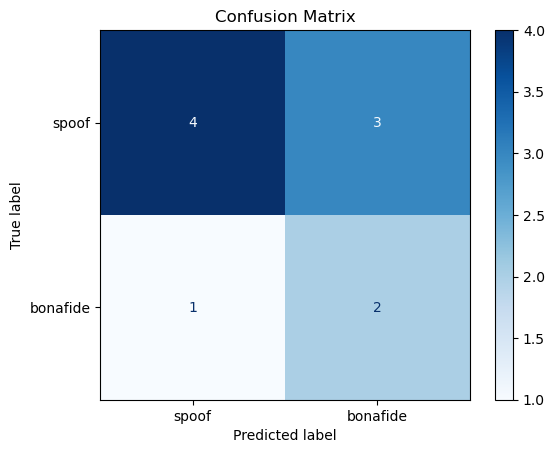

In [24]:
# CONFUSION MATRIX

cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
classes = ["spoof", "bonafide"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


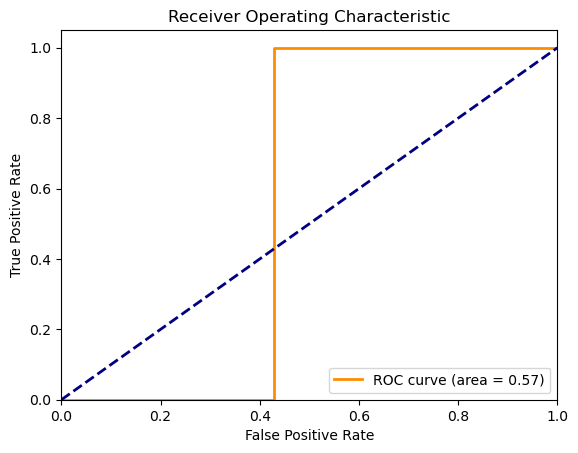

In [25]:
# ROC Curve

from sklearn.metrics import roc_curve, auc

# Predict using the loaded model
y_pred = model.predict(X_test)

# Get the predicted probabilities for the positive class
y_pred_prob = y_pred[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [26]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

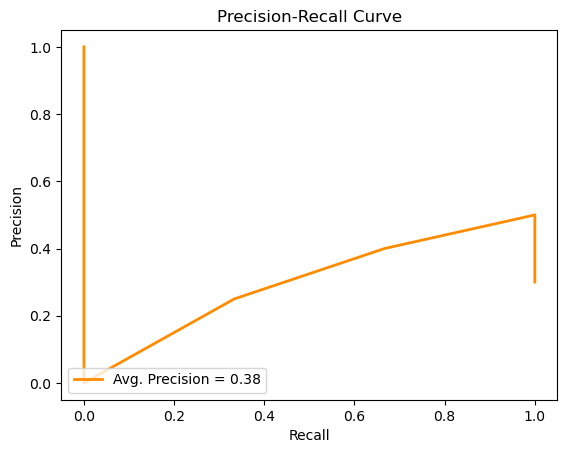

In [27]:
# Compute precision-recall curve and average precision score
precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
avg_precision = average_precision_score(y_true, y_pred_prob)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Avg. Precision = %0.2f' % avg_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [28]:
# Calibration Curve
from sklearn.calibration import calibration_curve

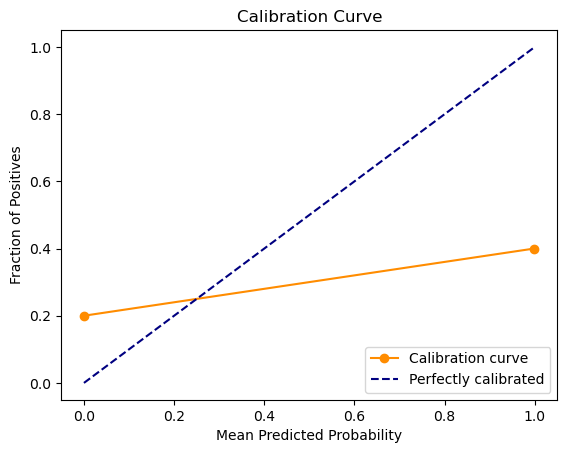

In [29]:
# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_true, y_pred_prob, n_bins=10)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc="lower right")
plt.show()

/home/u217652/tmp/ipykernel_339191/801023646.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_true, palette="Set2")


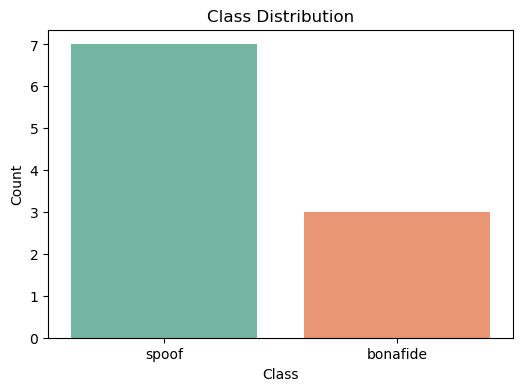

In [30]:
# Plot bar chart of class distribution

import seaborn as sns
import matplotlib.pyplot as plt


LABELS = ['spoof', 'bonafide']

plt.figure(figsize=(6, 4))
sns.countplot(x=y_true, palette="Set2")
plt.xticks(ticks=[0, 1], labels=LABELS)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

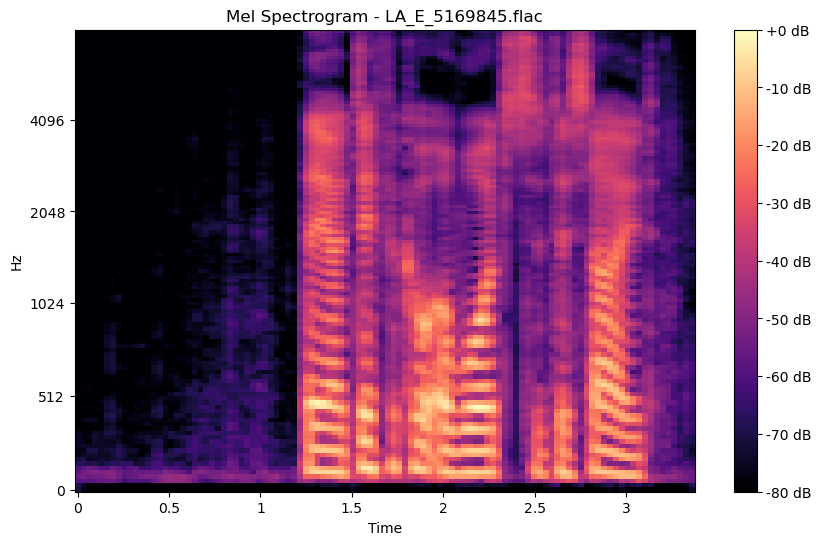

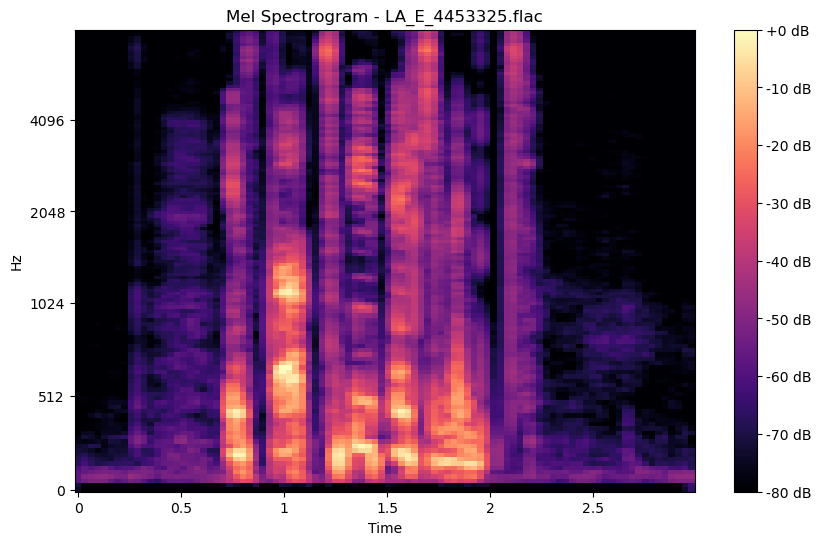

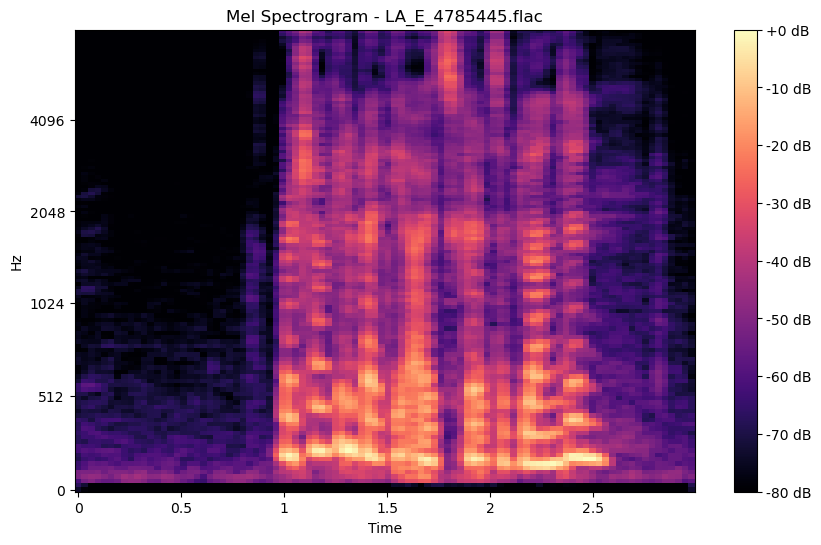

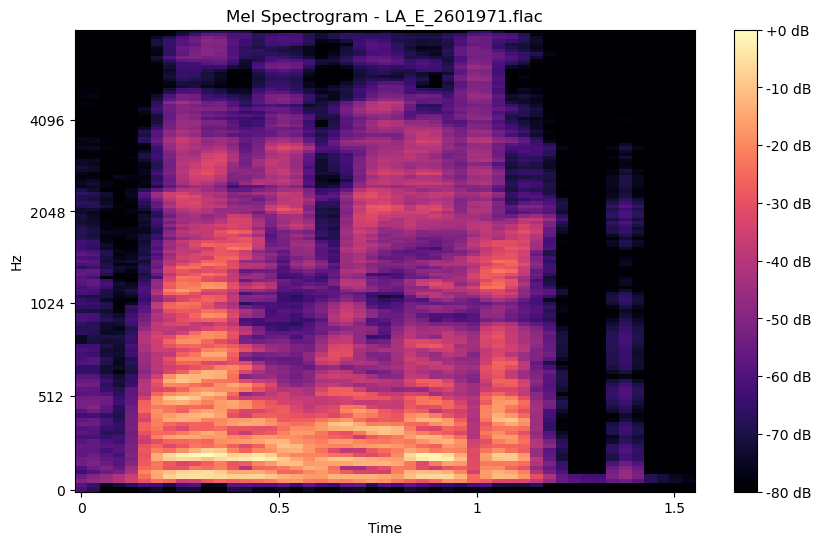

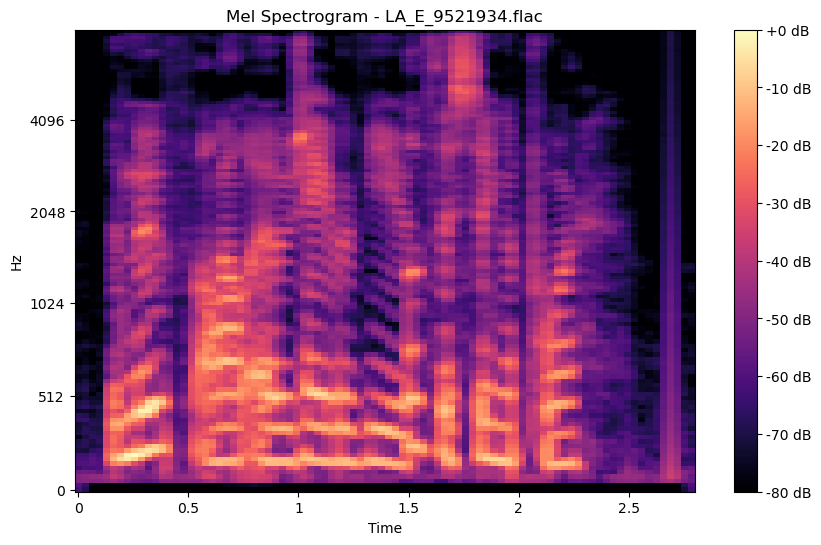

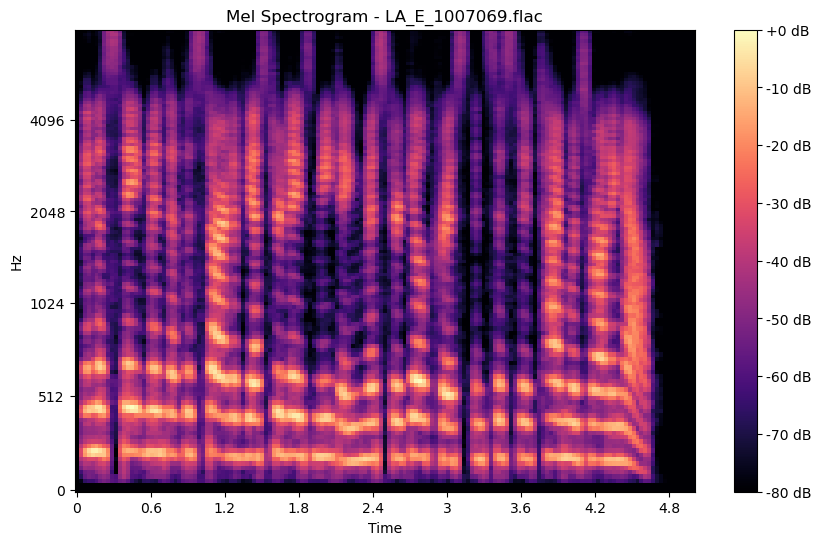

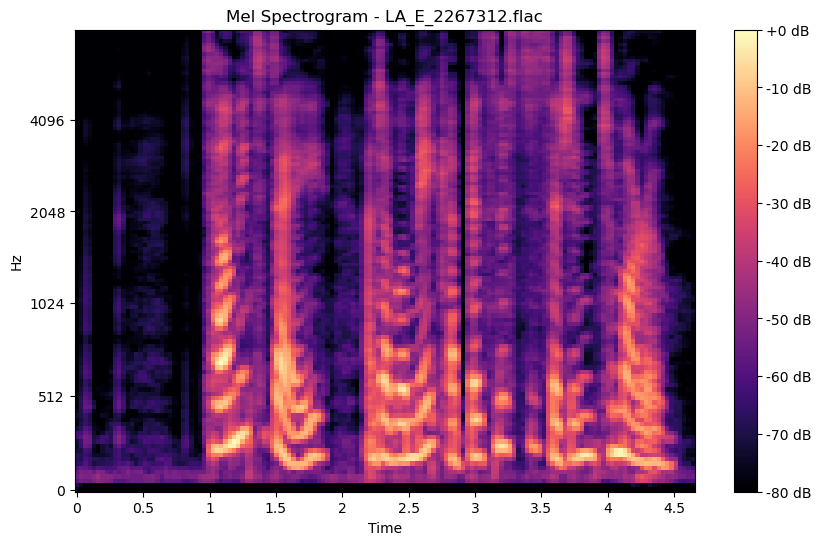

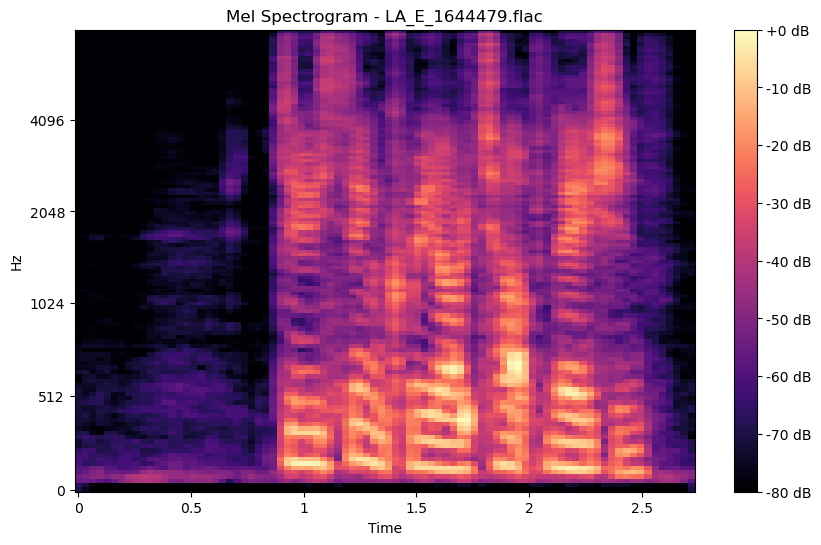

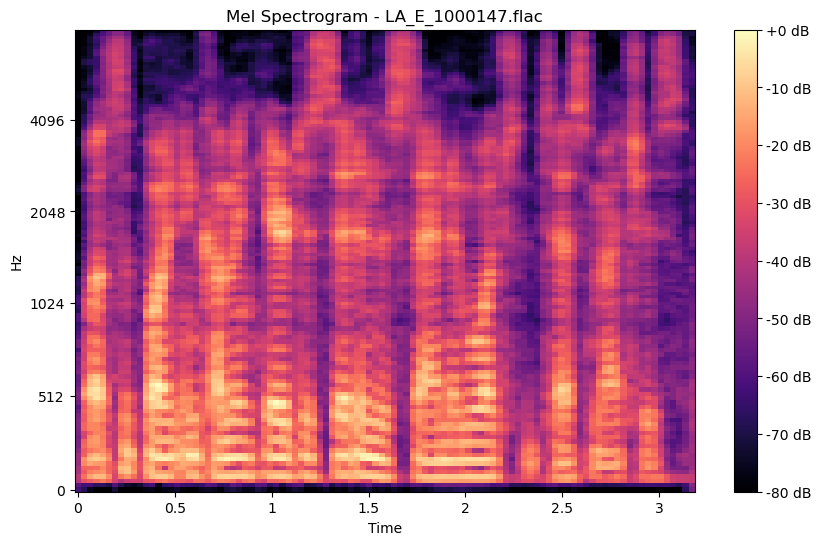

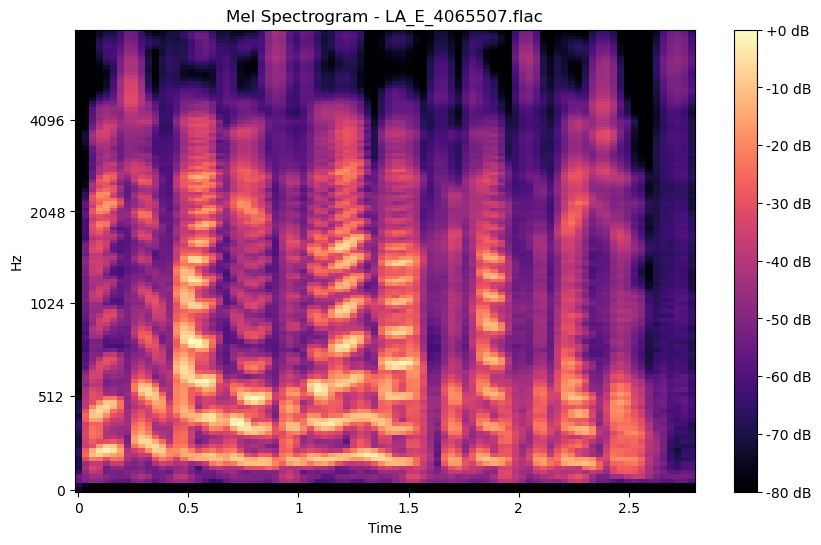

In [31]:
# Visualising Mel Spectrogram

import os
import librosa.display

# Folder containing .flac audio files
folder_path = "TestEvaluation"

# Get a list of all .flac files in the folder
flac_files = [file for file in os.listdir(folder_path) if file.endswith(".flac")]

# Define the hop length
HOP_LENGTH = 512  # Adjust this value based on your needs

# Loop through each .flac file and visualize its Mel spectrogram
for flac_file in flac_files:
    audio_file_path = os.path.join(folder_path, flac_file)

    # Load the audio file using librosa
    audio, _ = librosa.load(audio_file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Calculate the Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Plot the Mel spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram - {flac_file}')
    plt.show()


In [6]:
from keras.utils import plot_model
from tensorflow.keras.models import load_model
import tensorflow as tf

In [7]:
mod = tf.keras.saving.load_model("audio_classifier.h5")
plot_model(mod, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

AttributeError: module 'tensorflow.keras' has no attribute 'saving'